In [17]:
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
fs = fetch_olivetti_faces()
from keras.utils import np_utils
import h5py
import tensorflow as tf
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import adam_v2
import time
import cv2
from PIL import Image,ImageOps

In [3]:
print(fs.keys())

dict_keys(['data', 'images', 'target', 'DESCR'])


In [4]:
print(fs.images.shape)
print(fs.data.shape)
print(fs.target.shape)

(400, 64, 64)
(400, 4096)
(400,)


In [5]:
data = fetch_olivetti_faces()
df = pd.DataFrame(data.data)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4056,4057,4058,4059,4060,4061,4062,4063,4064,4065,4066,4067,4068,4069,4070,4071,4072,4073,4074,4075,4076,4077,4078,4079,4080,4081,4082,4083,4084,4085,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,0.702479,0.698347,0.694215,0.698347,0.690083,0.694215,0.690083,0.698347,0.702479,0.702479,0.698347,0.706612,0.710744,0.719008,0.727273,0.756198,0.772727,0.776860,0.776860,0.756198,0.760331,0.780992,0.760331,0.768595,0.756198,0.739669,0.743802,0.739669,0.743802,0.719008,...,0.756198,0.752066,0.694215,0.690083,0.681818,0.681818,0.657025,0.648760,0.636364,0.632231,0.636364,0.623967,0.619835,0.644628,0.681818,0.685950,0.677686,0.681818,0.673554,0.665289,0.632231,0.582645,0.541322,0.537190,0.537190,0.553719,0.570248,0.611570,0.632231,0.657025,0.665289,0.669421,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,0.710744,0.698347,0.702479,0.706612,0.706612,0.714876,0.714876,0.706612,0.698347,0.714876,0.698347,0.723140,0.731405,0.743802,0.756198,0.772727,0.768595,0.785124,0.764463,0.756198,0.731405,0.743802,0.735537,0.719008,0.706612,0.714876,0.719008,0.710744,0.710744,0.706612,...,0.673554,0.661157,0.652893,0.628099,0.632231,0.644628,0.640496,0.628099,0.632231,0.636364,0.628099,0.619835,0.619835,0.603306,0.590909,0.561983,0.516529,0.533058,0.578512,0.570248,0.561983,0.557851,0.545455,0.111570,0.095041,0.152893,0.152893,0.128099,0.136364,0.132231,0.136364,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,0.702479,0.706612,0.706612,0.714876,0.710744,0.706612,0.706612,0.706612,0.723140,0.719008,0.719008,0.710744,0.710744,0.752066,0.756198,0.764463,0.785124,0.797521,0.838843,0.826446,0.842975,0.847107,0.830579,0.818182,0.793388,0.768595,0.760331,0.756198,0.739669,0.710744,...,0.719008,0.714876,0.706612,0.685950,0.665289,0.652893,0.644628,0.636364,0.623967,0.636364,0.657025,0.644628,0.677686,0.681818,0.690083,0.690083,0.690083,0.681818,0.661157,0.652893,0.636364,0.586777,0.545455,0.570248,0.607438,0.603306,0.595041,0.578512,0.607438,0.413223,0.074380,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,0.537190,0.566116,0.574380,0.586777,0.611570,0.632231,0.640496,0.657025,0.673554,0.694215,0.702479,0.719008,0.727273,0.719008,0.723140,0.710744,0.739669,0.747934,0.756198,0.756198,0.764463,0.772727,0.785124,0.785124,0.805785,0.818182,0.805785,0.809917,0.793388,0.789256,...,0.400826,0.442149,0.479339,0.512397,0.537190,0.557851,0.566116,0.586777,0.586777,0.615702,0.632231,0.661157,0.681818,0.673554,0.714876,0.710744,0.706612,0.690083,0.681818,0.623967,0.615702,0.586777,0.582645,0.578512,0.590909,0.590909,0.611570,0.628099,0.644628,0.657025,0.652893,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,0.739669,0.739669,0.764463,0.756198,0.764463,0.785124,0.793388,0.797521,0.814050,0.809917,0.809917,0.818182,0.830579,0.830579,0.842975,0.838843,0.838843,0.838843,0.830579,0.818182,0.805785,0.801653,0.797521,0.793388,0.793388,0.785124,0.797521,0.801653,0.793388,0.793388,...,0.561983,0.557851,0.574380,0.595041,0.599174,0.611570,0.623967,0.636364,0.669421,0.681818,0.698347,0.698347,0.714876,0.710744,0.764463,0.756198,0.785124,0.797521,0.739669,0.714876,0.681818,0.619835,0.293388,0.144628,0.152893,0.152893,0.157025,0.148760,0.161157,0.161157,0.190083,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554


In [6]:
df_tgt = pd.DataFrame(data.target, columns=['target'])
df_tgt.head()

,target
0,0
1,0
2,0
3,0
4,0


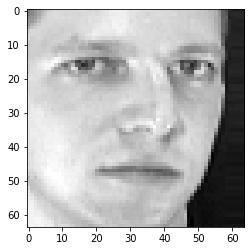

In [7]:
plt.gray()
plt.imshow(df.loc[1,:].values.reshape(64,64))

In [8]:
x_train, x_test, y_train, y_test = train_test_split(
    fs.data, fs.target, test_size = 0.25, random_state = 0
)

x_train = x_train.reshape(300, 64, 64, 1)
x_test = x_test.reshape(100, 64, 64, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
num_classes = 40
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [9]:
def face(images, n):
  fig = plt.figure(figsize=(12,12))
  fig.subplots_adjust(left=0, right=1, bottom=0, 
                      top=1, hspace=0.05, wspace=0.05)
  for i in range(n):
    p = fig.add_subplot(20, 20, i+1, xticks=[], yticks=[])
    dt = images[i].reshape(64,64)
    p.imshow(dt, cmap=plt.cm.bone)
  plt.show()

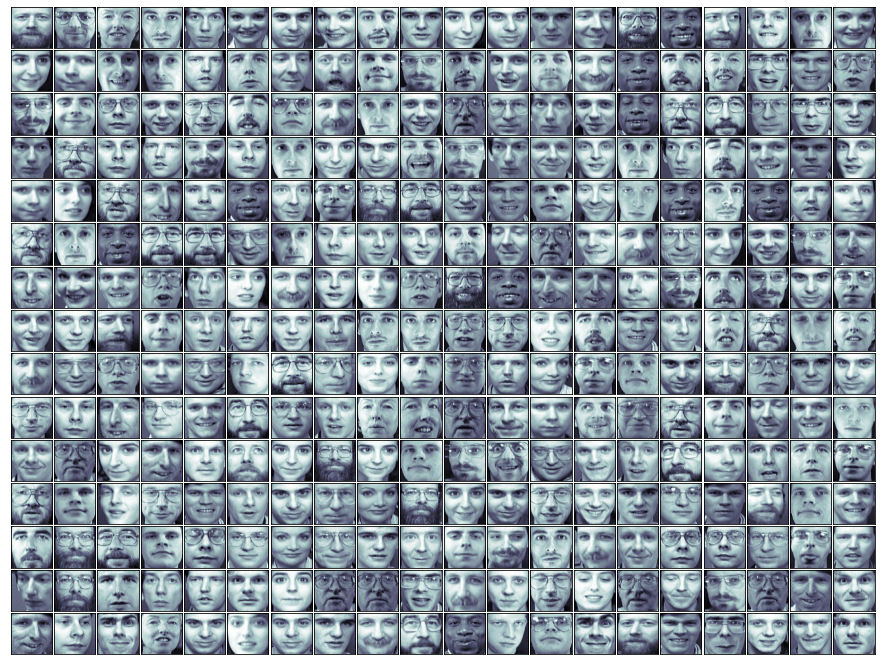

In [10]:
face(x_train, 300)

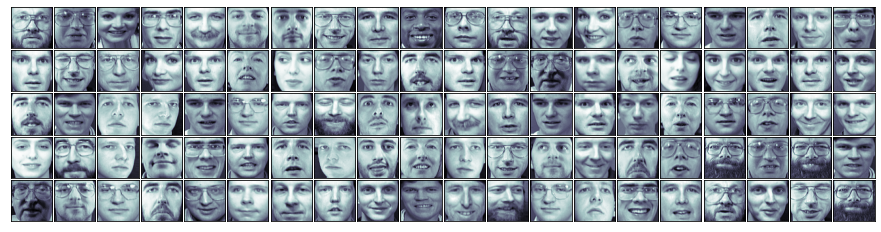

In [11]:
face(x_test, 100)

In [12]:
model = Sequential()
model.add(Conv2D(16, (3, 3), 
          input_shape=(64, 64, 1), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))                
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))                
model.add(Dropout(0.25))                                 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))                                 
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(optimizer= "adam", loss='mse', metrics=["accuracy"])

startTime = time.time()

history = model.fit(x_train, y_train, batch_size=10, epochs=20,
                    verbose=1, validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("Computation time:{0:.3f} sec".format(time.time() - startTime))
model.save_weights('model.hdf5')
model.save("model.h5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

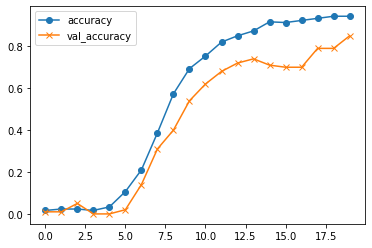

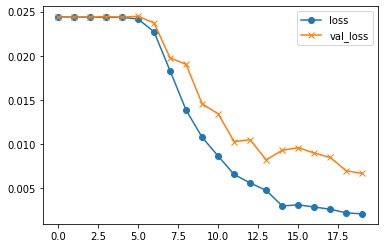

In [14]:
plt.plot(history.history["accuracy"],label="accuracy",ls="-",marker="o")
plt.plot(history.history["val_accuracy"],label="val_accuracy",ls="-",marker="x")
plt.ylabel=("accuracy")
plt.xlabel=("epoch")
plt.legend(loc="best")
plt.show()
plt.plot(history.history["loss"],label="loss",ls="-",marker="o")
plt.plot(history.history["val_loss"],label="val_loss",ls="-",marker="x")
plt.ylabel=("accuracy")
plt.xlabel=("epoch")
plt.legend(loc="best")
plt.show()

In [21]:
def show_prediction():
    y = model.predict(x_test)  
    cklst_test = []
    cklst = []
    
    for i in range(20):
        wk_test = y_test[i, :]
        cklst_test = cklst_test + [np.argmax(wk_test)]
        
        wk = y[i, :]
        cklst = cklst + [np.argmax(wk)]

    print(cklst_test)
    print(cklst)
    
show_prediction()

[13, 30, 34, 19, 24, 6, 15, 26, 14, 21, 3, 13, 11, 34, 1, 5, 29, 14, 20, 19]
[13, 30, 34, 19, 24, 6, 15, 26, 2, 21, 3, 13, 11, 34, 1, 5, 29, 3, 20, 19]


None (64, 64) L
None (64, 64) L
None (64, 64) L
None (64, 64) L


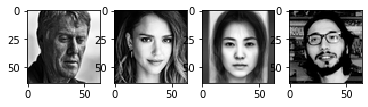

In [23]:
data_lst= ["face1.jpg","face2.jpg", "face3.jpg","face4.jpg"]
png_face_lst = []

n = len(data_lst)
for i in range(n):
    wd_lst = []
    image = Image.open(data_lst[i]).convert('L') 
    image = image.resize((64,64), Image.LANCZOS) 
    wd_lst = data_lst[i].split(".")
    image.save("png_"+ wd_lst[0] + ".png")
    png_face_lst.append("png_"+ wd_lst[0] + ".png")
    
for i in range(n):
    image = Image.open(png_face_lst[i]).convert('L') 
    print(image.format, image.size, image.mode)

    plt.subplot(1,4, i+1)
    #im_list = np.asarray(image)
    #plt.imshow(image, cmap=plt.cm.bone) # bone -->  単色濃淡
    plt.imshow(image,cmap='gray',  interpolation='nearest')
plt.show()

png_data = np.array(png_face_lst)
np.save("face.npy", png_data)

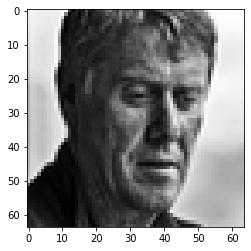

16


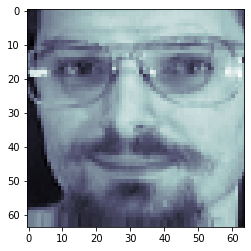

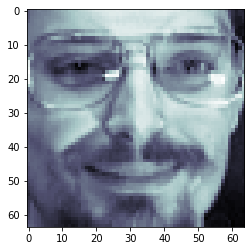

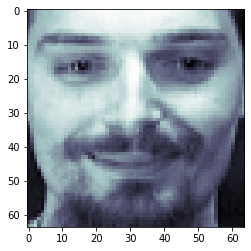

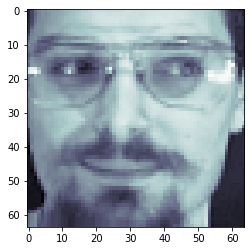

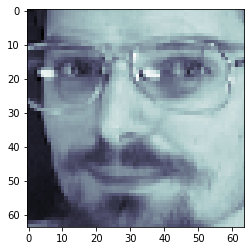

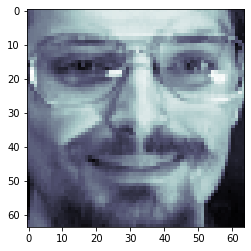

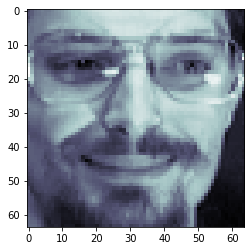

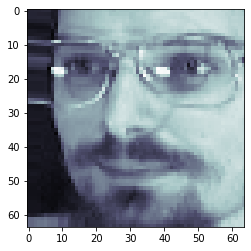

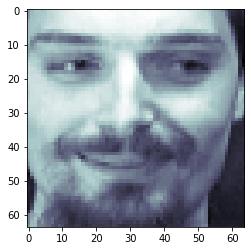

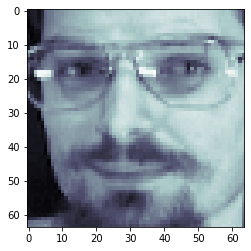

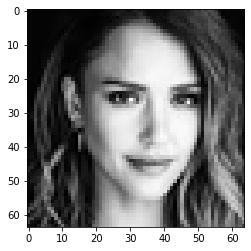

39


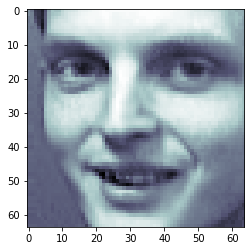

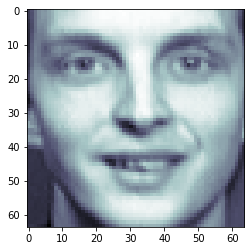

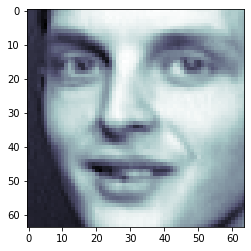

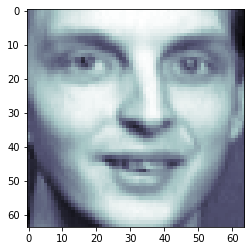

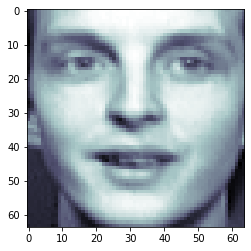

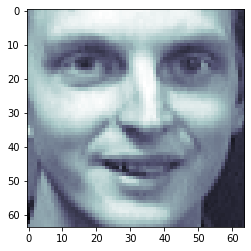

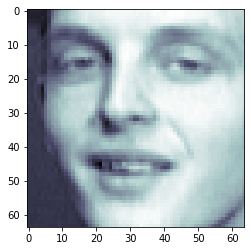

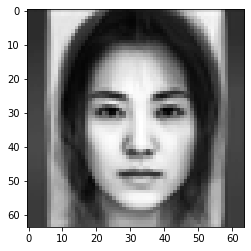

35


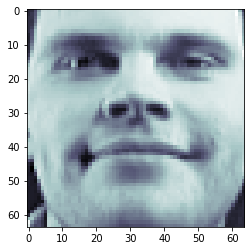

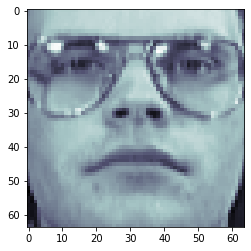

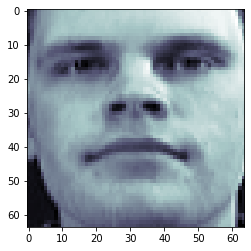

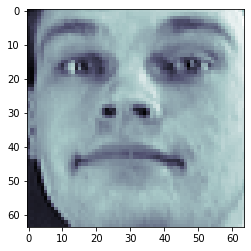

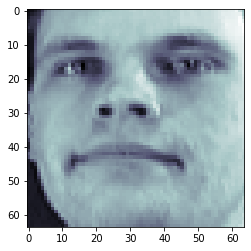

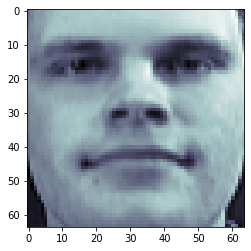

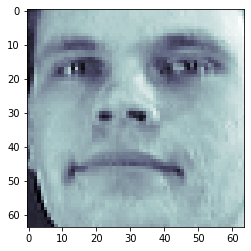

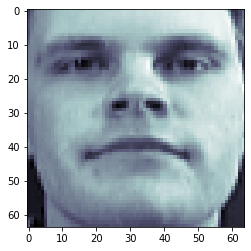

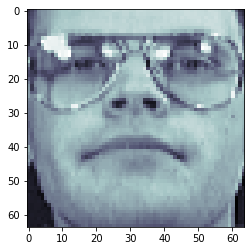

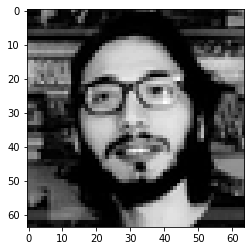

36


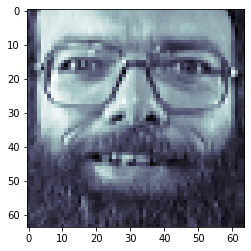

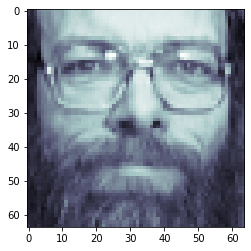

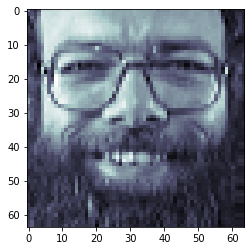

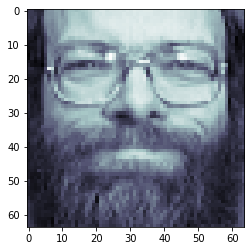

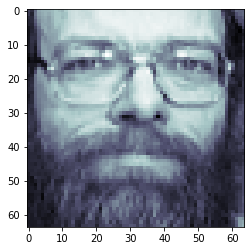

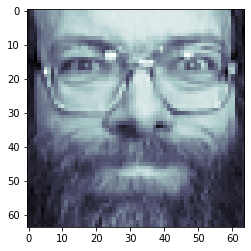

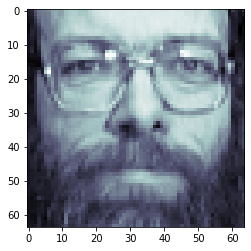

In [24]:
x_train, x_test, y_train, y_test = train_test_split(fs.data, fs.target, test_size=0.25,random_state=0)
x_train = x_train.reshape(300, 64, 64, 1)

model = tf.keras.models.load_model("model.h5", compile=False)
png_data_lst = np.load("face.npy")
n = len(png_data_lst)

for i in range(n):
    image = Image.open(png_data_lst[i])
    image = image.resize((64,64), Image.LANCZOS) 
    plt.imshow(image, cmap='gray',  interpolation='nearest')
    plt.show()

    in_data = np.array(image)
        
    data_arr = in_data.reshape(-1,64,64,1)
    
    pred_lst = model.predict(data_arr)
    pred = np.argmax(pred_lst)
    print(pred)
    for i in range(300):
        if y_train[i] == pred:
        
            dt = x_train[i,:,:].reshape(64,64)
            plt.imshow(dt,cmap=plt.cm.bone)
            plt.show()

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

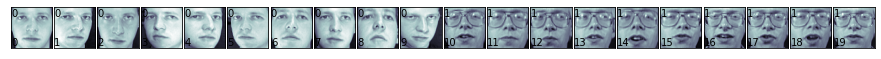

In [17]:
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import sem

faces = fetch_olivetti_faces()
print(faces.DESCR)
 
print(faces.keys())
 
# 要素数の確認
print(faces.images.shape)
print(faces.data.shape)
print(faces.target.shape)
 
def print_faces(images, target, top_n):
    #出力する画像のサイズを設定する
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1,hspace=0.05,wspace=0.05)
    for i in range(top_n):
        p = fig.add_subplot(20, 20,i+1,xticks=[],yticks=[])
        p.imshow(images[i],cmap=plt.cm.bone)
 
        # 正解ラベルを表示
        p.text(0,14,str(target[i]))
        p.text(0,60,str(i))
 
print_faces(faces.images, faces.target,20)

svc_1 = SVC(kernel='linear')

x_train, x_test, y_train, y_test = train_test_split(
    faces.data, faces.target,test_size=0.25,random_state=0)
 
# 交差検定
def evaluate_cross_validation(clf, x, y, K):
 
    cv = KFold(n_splits=K, random_state=0,shuffle=True)
    scores = cross_val_score(clf,x,y,cv=cv)
    print(scores)
    print ("Mean score: {} (+/-{})".format( np.mean (scores), sem(scores)))
 
evaluate_cross_validation(svc_1,x_train,y_train,5)
 
 
def train_and_evaluate(clf,x_train,x_test,y_train,y_test):
    clf.fit(x_train,y_train)
 
    print("Accuracy(学習データ):",clf.score(x_train,y_train))
    print("Accuracy(テストデータ):",clf.score(x_test,y_test))
 
train_and_evaluate(svc_1, x_train,x_test,y_train,y_test)